In [1]:
import tensorflow as tf
import os
import math
import numpy as np
from matplotlib import pyplot as plt


# Some hyper-parameters:
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 20            # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_height, img_width = x_train.shape[1:]
img_channels = 1
input_shape  = (img_height, img_width, img_channels)

# For the following experiments, we will however not use the class labels:
del y_train
del y_test

# Normalizing the image data:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Even though we will use again a basic fully-coonected network, we need to preserve the image format
# of the sample this time, to use the Keras image pre-processing tool to add noise. Therefore, 
# the augmented images will be flattened by the network itself via a initial Flatten() layer.
x_train = x_train.reshape((-1, img_height, img_width, img_channels))
x_test = x_test.reshape((-1, img_height, img_width, img_channels))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of testing set: {}".format(x_test.shape))

# Setting some variables:
batch_size = 64
train_steps_per_epoch = len(x_train) // batch_size
val_steps_per_epoch = len(x_test) // batch_size

Shape of training set: (60000, 28, 28, 1)
Shape of testing set: (10000, 28, 28, 1)


In [3]:
code_size = 32

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

inputs = Input(shape=input_shape, name='input')

# As previously mentioned, the image flattening is done here:
inputs_flat = Flatten()(inputs)

# Encoding layers:
enc_1 = Dense(128, activation='relu', name='enc_dense1')(inputs_flat)
enc_2 = Dense(64, activation='relu', name='enc_dense2')(enc_1)
code = Dense(code_size, activation='relu', name='enc_dense3')(enc_2)

# Decoding layers:
dec_1 = Dense(64, activation='relu', name='dec_dense1')(code)
dec_2 = Dense(128, activation='relu', name='dec_dense2')(dec_1)
decoded = Dense(np.prod(input_shape), activation='sigmoid', name='dec_dense3')(dec_2)
# note: we use a sigmoid for the last activation, as we want the output values
# to be between 0 and 1, like the input ones.

# Finally, we reshape the decoded data so it has the same shape as the input samples:
decoded_reshape = Reshape(input_shape)(decoded)

# Auto-encoder model:
autoencoder = Model(inputs, decoded_reshape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320  

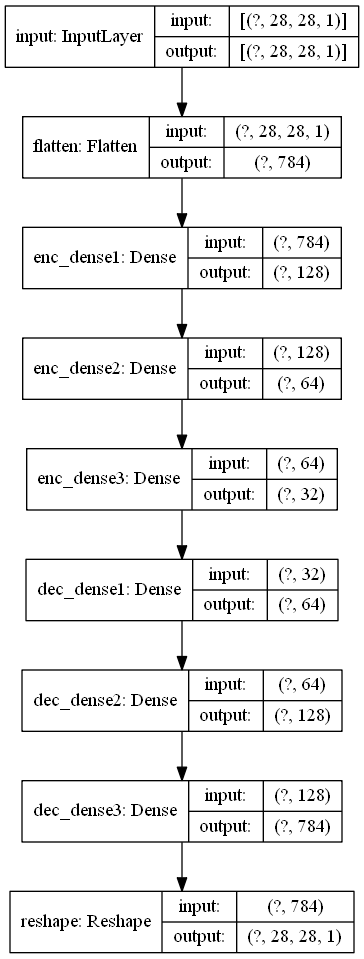

In [5]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

In [6]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_image_grid(images, titles=None, figure=None,
                    grayscale=False, transpose=False):
    """
    Plot a grid of n x m images.
    :param images:       Images in a n x m array
    :param titles:       (opt.) List of m titles for each image column
    :param figure:       (opt.) Pyplot figure (if None, will be created)
    :param grayscale:    (opt.) Flag to draw the images in grayscale
    :param transpose:    (opt.) Flag to transpose the grid
    :return:             Pyplot figure filled with the images
    """
    num_cols, num_rows = len(images), len(images[0])
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0]

    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.

    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {}
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0)

    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], wspace=wspace, hspace=hspace)

        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            # ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
            ax_img.imshow(images[j][i], **imshow_params)

    figure.tight_layout()
    return figure

In [7]:

def add_noise(img, min_noise_factor=.3, max_noise_factor=.6):
    """
    Add some random noise to an image, from a uniform distribution.
    :param img:               Image to corrupt
    :param min_noise_factor:  Min. value for the noise random average amplitude
    :param max_noise_factor:  Max. value for the noise random average amplitude
    :return:                  Corrupted image
    """
    # Generating and applying noise to image:
    noise_factor = np.random.uniform(min_noise_factor, max_noise_factor)
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=img.shape) 
    img_noisy = img + noise
    
    # Making sure the image value are still in the proper range:
    img_noisy = np.clip(img_noisy, 0., 1.)
    
    return img_noisy

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


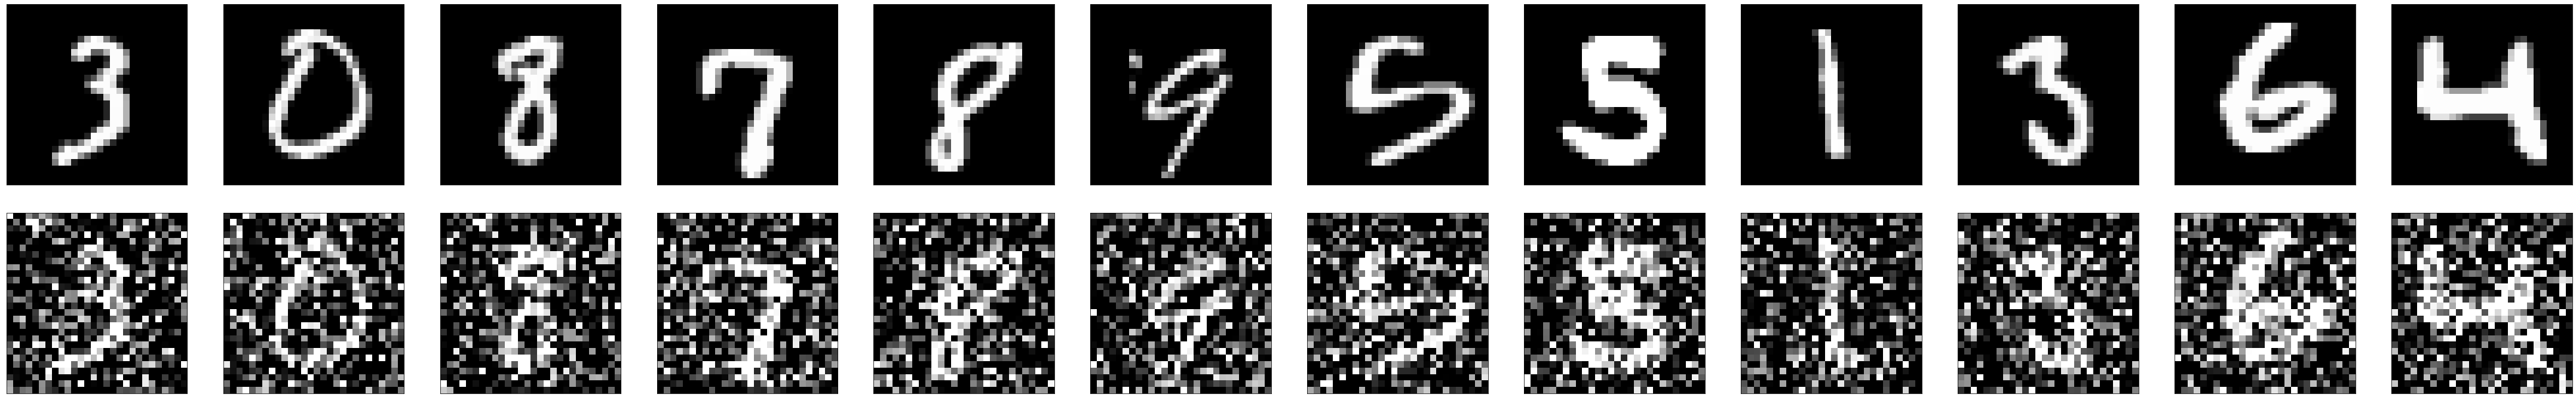

In [8]:
num_show = 12
random_image_indices = np.random.choice(len(x_test), size=num_show)

orig_samples = x_test[random_image_indices]
noisy_samples = add_noise(orig_samples)

fig = plot_image_grid([np.squeeze(orig_samples), np.squeeze(noisy_samples)],
                      grayscale=True, transpose=True)
fig.show()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We define our Keras generator, passing our noisy function as pre-processing step:
train_datagen = ImageDataGenerator(preprocessing_function=add_noise)

# Then we pass our dataset to the generator and specify how the yielded batch should be
# (batch size, shuffling or not, etc.).
train_generator = train_datagen.flow(x_train, x_train, 
                                     batch_size=batch_size, shuffle=True)
train_generator

In [10]:
x_test_noisy = add_noise(x_test)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_generator = train_datagen.flow(x_test_noisy, x_test,
                                   batch_size=batch_size, shuffle=False)

In [11]:
import functools

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

In [12]:
import io

def figure_to_rgb_array(fig):
    """
    Convert figure into a RGB array
    :param fig:         PyPlot Figure
    :return:            RGB array
    """
    figure_buffer = io.BytesIO()
    fig.savefig(figure_buffer, format='png')
    figure_buffer.seek(0)
    figure_string = figure_buffer.getvalue()
    return figure_string


def figure_to_summary(fig, name, step):
    """
    Convert figure into TF summary
    :param fig:             Figure
    :param tag:             Summary name
    :return:                Summary step
    """
    # Transform figure into PNG buffer:
    figure_string = figure_to_rgb_array(fig)

    # Transform PNG buffer into image tensor:
    figure_tensor = tf.image.decode_png(figure_string, channels=4)
    figure_tensor = tf.expand_dims(figure_tensor, 0) # adding batch dimension

    # Using Proto to convert the image string into a summary:
    figure_summary = tf.summary.image(name, figure_tensor, step)

    return figure_summary



class TensorBoardImageGridCallback(tf.keras.callbacks.Callback):
    """ Keras callback for generative models, to draw grids of
        input/predicted/target images into Tensorboard every epoch.
    """

    def __init__(self, log_dir, input_images, target_images=None, tag='images',
                 figsize=(10, 10), dpi=300, grayscale=False, transpose=False,
                 preprocess_fn=None):
        """
        Initialize the Callback.
        :param log_dir:         Folder to write the image summaries into
        :param input_images:    List of input images to use for the grid
        :param target_images:   (opt.) List of target images for the grid
        :param tag:             Tag to name the Tensorboard summary
        :param figsize:         Pyplot figure size for the grid
        :param dpi:             Pyplot figure DPI
        :param grayscale:       Flag to plot the images as grayscale
        :param transpose:       Flag to transpose the image grid
        :param preprocess_fn:   (opt.) Function to pre-process the
                                input/predicted/target image lists before plotting
        """
        super().__init__()

        self.summary_writer = tf.summary.create_file_writer(log_dir)

        self.input_images, self.target_images = input_images, target_images
        self.tag = tag
        self.postprocess_fn = preprocess_fn

        self.image_titles = ['images', 'predicted']
        if self.target_images is not None:
            self.image_titles.append('ground-truth')

        # Initializing the figure:
        self.fig = plt.figure(num=0, figsize=figsize, dpi=dpi)
        self.grayscale = grayscale
        self.transpose = transpose

    def on_epoch_end(self, epoch, logs={}):
        """
        Plot into Tensorboard a grid of image results.
        :param epoch:   Epoch num
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """

        # Get predictions with current model:
        predicted_images = self.model.predict_on_batch(self.input_images)
        if self.postprocess_fn is not None:
            input_images, predicted_images, target_images = self.postprocess_fn(
                self.input_images, predicted_images, self.target_images)
        else:
            input_images, target_images = self.input_images, self.target_images

        # Fill figure with images:
        grid_imgs = [input_images, predicted_images]
        if target_images is not None:
            grid_imgs.append(target_images)
        self.fig.clf()
        self.fig = plot_image_grid(grid_imgs, titles=self.image_titles, figure=self.fig,
                                   grayscale=self.grayscale, transpose=self.transpose)

        with self.summary_writer.as_default():
            # Transform into summary:
            figure_summary = figure_to_summary(self.fig, self.tag, epoch)

            # # Finally, log it:
            # self.summary_writer.add_summary(figure_summary, global_step=epoch)
        self.summary_writer.flush()

    def on_train_end(self, logs={}):
        """
        Close the resources used to plot the grids.
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """
        self.summary_writer.close()
        plt.close(self.fig)

In [36]:
import collections
from keras_custom_callbacks import SimpleLogCallback

model_dir  = os.path.join('.', 'models', 'ae_denoising_mnist')

metrics_to_print = collections.OrderedDict([("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("psnr", "psnr"), 
                                            ("v-psnr", "val_psnr")])
callbacks  = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1),
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=noisy_samples, target_images=orig_samples, 
        tag='ae_results', figsize=(len(noisy_samples) * 3, 3 * 3), 
        grayscale=True, transpose=True,
        preprocess_fn=lambda img, pred, gt: (
            # Squeezing the images from H x W x 1 to H x W, otherwise Pyplot complains:
            np.squeeze(img, -1), np.squeeze(pred, -1), np.squeeze(gt, -1)))
]

autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=[psnr_metric])

# `model.fit_generator()` works quite similarly to `model.fit()` 
# used with tf.data inputs (c.f. notebooks for Chapter 4).
# In other words, we need to specify the number of batches ("steps") per epoch, 
# for Keras to keep track.
history = autoencoder.fit_generator(
    train_generator, steps_per_epoch=train_steps_per_epoch, epochs=num_epochs,
    validation_data=val_generator, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Training: start.
Epoch  0/20: loss = 0.114; v-loss = 0.128; psnr = 18.256; v-psnr = 17.171
Epoch  1/20: loss = 0.113; v-loss = 0.128; psnr = 18.282; v-psnr = 17.150
Epoch  2/20: loss = 0.113; v-loss = 0.127; psnr = 18.308; v-psnr = 17.179
Epoch  3/20: loss = 0.113; v-loss = 0.128; psnr = 18.325; v-psnr = 17.140
Epoch  4/20: loss = 0.113; v-loss = 0.127; psnr = 18.347; v-psnr = 17.214
Epoch  5/20: loss = 0.112; v-loss = 0.128; psnr = 18.371; v-psnr = 17.126
Epoch  6/20: loss = 0.112; v-loss = 0.127; psnr = 18.389; v-psnr = 17.226
Epoch  7/20: loss = 0.112; v-loss = 0.127; psnr = 18.401; v-psnr = 17.213
Epoch  8/20: loss = 0.112; v-loss = 0.128; psnr = 18.427; v-psnr = 17.168
Epoch  9/20: loss = 0.112; v-loss = 0.126; psnr = 18.439; v-psnr = 17.244
Epoch 10/20: loss = 0.112; v-loss = 0.126; psnr = 18.444; v-psnr = 17.243
Epoch 11/20: loss = 0.111; v-loss = 0.126; psnr = 18.463; v-psnr = 17.271
Epoch 12/20: loss = 0.111; v-loss = 0.126; psnr = 18.487; v-psnr = 17.282
Epoch 13/20: loss = 0

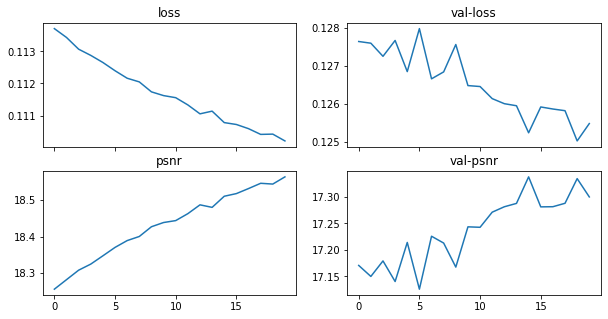

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['psnr'])
ax[1, 1].plot(history.history['val_psnr'])

plt.show()

C:\Users\Nickel\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


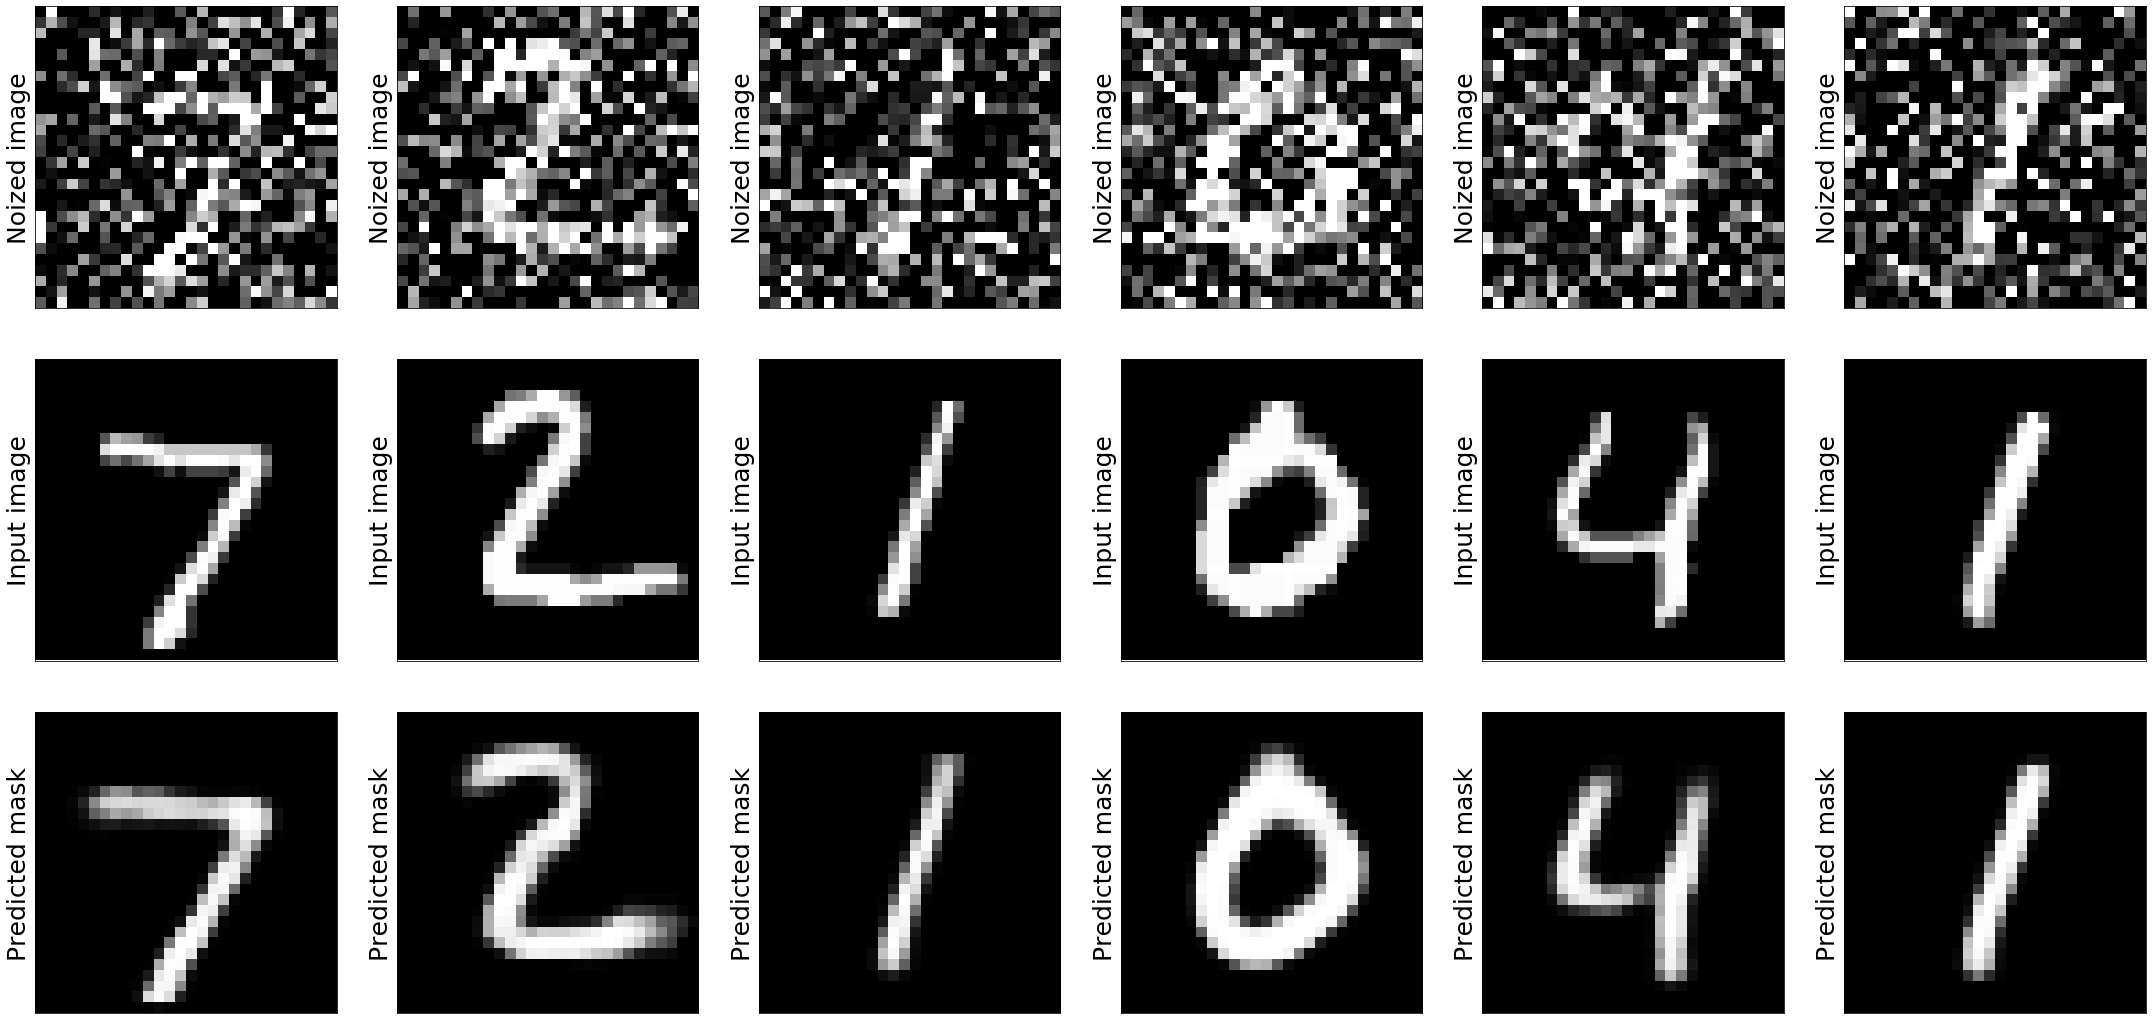

In [81]:
pred = autoencoder.predict(x_test)

num_show = 6

orig_samples = x_test[:num_show]
noisy_samples = add_noise(orig_samples)
predict_samples = pred[:num_show]


fig = plot_image_grid([np.squeeze(noisy_samples),
                       np.squeeze(orig_samples),
                       np.squeeze(predict_samples),],
                      titles=['Noized image', 'Input image', 'Predicted mask'],
                      grayscale=True, transpose=True)
fig.show()